In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, make_scorer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.preprocessing import LabelBinarizer
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, average_precision_score
from sklearn.preprocessing import LabelBinarizer
#!pip install -U joblib
#!pip install --upgrade pip
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt




# 1. Split

In [ ]:
data = pd.read_csv('/Applications/hello/论文/data_to_fit_without_worldbank.csv')
# separate the features and target variable
X = data.drop(columns=['Type', 'Market', 'ESG_Rating'], errors='ignore')
y = data['ESG_Rating']
# hot-encode the categorical features
X_encoded = pd.get_dummies(X, drop_first=True)
feature_names = X_encoded.columns
# encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42)



In [7]:
print(label_encoder.classes_)


['A' 'B' 'C' 'D']


# 2. Logistic regression

In [ ]:
# define the model
param_grid = {
    'C': [0.001, 0.01, 0.1, 1],
    'solver': ['newton-cg', 'lbfgs'],
    'max_iter': [1000,2000],
}


logistic_model = LogisticRegression(class_weight='balanced',random_state=42)

# grid search
grid_search = GridSearchCV(logistic_model, param_grid, scoring='f1_weighted', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# summarize the results
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)


Best Parameters: {'C': 1, 'max_iter': 1000, 'solver': 'newton-cg'}
Best F1 Score: 0.6439259933712247


In [ ]:
# train the model with the best parameters
best_params = grid_search.best_params_
best_logistic_model = LogisticRegression(
    **best_params,
    class_weight='balanced',  # 保持 class_weight='balanced'
    random_state=42
)

best_logistic_model.fit(X_train, y_train)

# evaluate the model
y_train_pred = best_logistic_model.predict(X_train)
y_train_pred_proba = best_logistic_model.predict_proba(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred, average='weighted')
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
train_auc = roc_auc_score(y_train_binarized, y_train_pred_proba, multi_class="ovr")
train_prauc = average_precision_score(y_train_binarized, y_train_pred_proba)

print("\nTrain Results:")
print("Accuracy:", train_accuracy)
print("F1 Score:", train_f1)
print("AUC:", train_auc)
print("prAUC:", train_prauc)

# evaluate the model on the test set
y_test_pred = best_logistic_model.predict(X_test)
y_test_pred_proba = best_logistic_model.predict_proba(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average='weighted')
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])
test_auc = roc_auc_score(y_test_binarized, y_test_pred_proba, multi_class="ovr")
test_prauc = average_precision_score(y_test_binarized, y_test_pred_proba)

print("\nTest Results:")
print("Accuracy:", test_accuracy)
print("F1 Score:", test_f1)
print("AUC:", test_auc)
print("prAUC:", test_prauc)


Train Results:
Accuracy: 0.702880658436214
F1 Score: 0.7021014632115555
AUC: 0.9027015288215023
prAUC: 0.769462134279195

Test Results:
Accuracy: 0.581573896353167
F1 Score: 0.5816691075145912
AUC: 0.8358200399393665
prAUC: 0.601264937716389


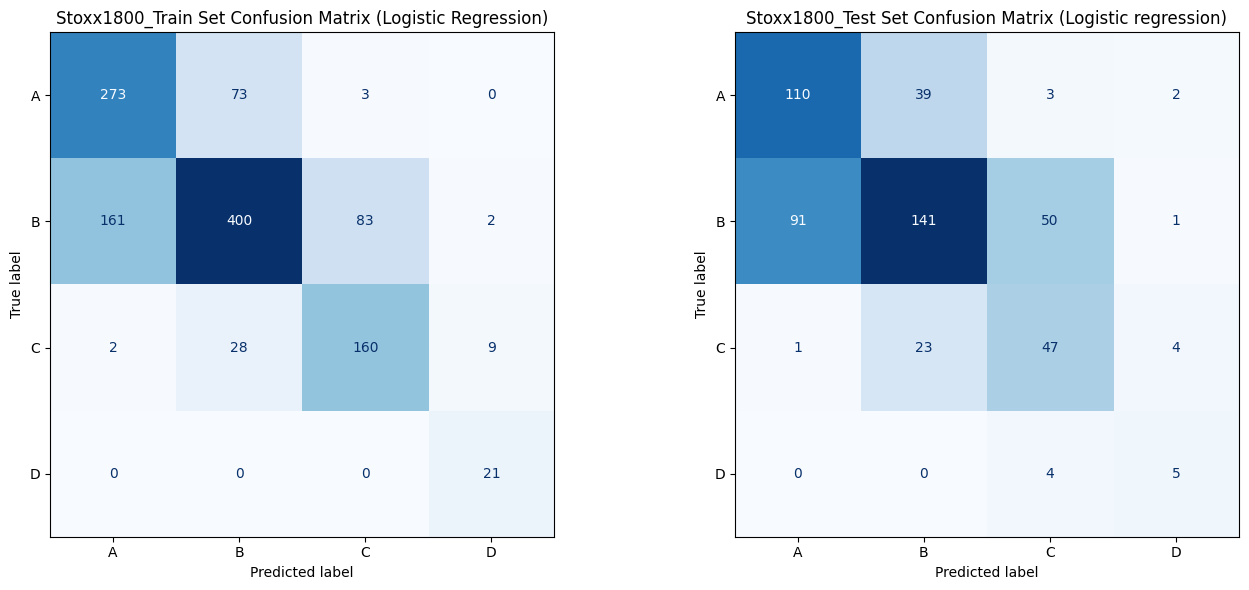

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# plot the confusion matrix
def plot_combined_confusion_matrices(y_train, y_train_pred, y_test, y_test_pred):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # training set confusion matrix
    cm_train = confusion_matrix(y_train, y_train_pred)
    disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=label_encoder.classes_)
    disp_train.plot(ax=axes[0], cmap=plt.cm.Blues, colorbar=False)
    axes[0].set_title('Stoxx1800_Train Set Confusion Matrix (Logistic Regression)')

    # test set confusion
    cm_test = confusion_matrix(y_test, y_test_pred)
    disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=label_encoder.classes_)
    disp_test.plot(ax=axes[1], cmap=plt.cm.Blues, colorbar=False)
    axes[1].set_title('Stoxx1800_Test Set Confusion Matrix (Logistic regression)')

    plt.tight_layout()
    plt.show()

# plot the confusion matrices
plot_combined_confusion_matrices(y_train, y_train_pred, y_test, y_test_pred)



# 3. Random Forest

## 3.2 best

In [ ]:
# define the model
best_rf_model = RandomForestClassifier(
    max_depth=50,
    max_features='log2',
    min_samples_leaf=5,
    min_samples_split=5,
    n_estimators=1000,
    random_state=42
)

# train the model
best_rf_model.fit(X_train, y_train)

# evaluate the model
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# for training set
y_train_pred = best_rf_model.predict(X_train)
y_train_pred_proba = best_rf_model.predict_proba(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred, average='weighted')
train_auc = roc_auc_score(y_train_binarized, y_train_pred_proba, multi_class="ovr")
train_prauc = average_precision_score(y_train_binarized, y_train_pred_proba)
print("Train Accuracy:", train_accuracy)
print("Train F1 Score:", train_f1)
print("Train AUC:", train_auc)
print("Train prAUC:", train_prauc)


# for test set
y_test_pred = best_rf_model.predict(X_test)
y_test_pred_proba = best_rf_model.predict_proba(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average='weighted')
test_auc = roc_auc_score(y_test_binarized, y_test_pred_proba, multi_class="ovr")
test_prauc = average_precision_score(y_test_binarized, y_test_pred_proba)
print("Test Accuracy:", test_accuracy)
print("Test F1 Score:", test_f1)
print("Test AUC:", test_auc)
print("Test prAUC:", test_prauc)

Train Accuracy: 0.8477366255144033
Train F1 Score: 0.8396070309326258
Train AUC: 0.9841616124579398
Train prAUC: 0.9316424695707164
Test Accuracy: 0.6621880998080614
Test F1 Score: 0.6380633928368219
Test AUC: 0.8526625060626614
Test prAUC: 0.6469663216797474


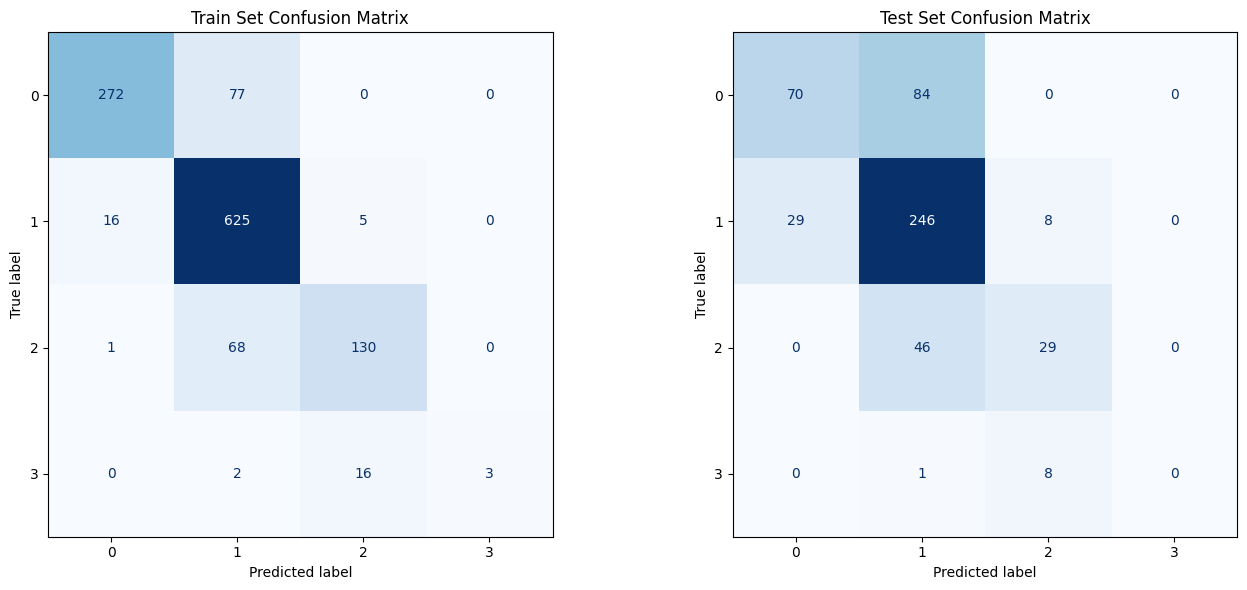

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# plot the confusion matrix
def plot_combined_confusion_matrices(y_train, y_train_pred, y_test, y_test_pred):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # training set confusion matrix
    cm_train = confusion_matrix(y_train, y_train_pred)
    disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=[0, 1, 2, 3])
    disp_train.plot(ax=axes[0], cmap=plt.cm.Blues, colorbar=False)
    axes[0].set_title('Train Set Confusion Matrix')

    # test set confusion
    cm_test = confusion_matrix(y_test, y_test_pred)
    disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=[0, 1, 2, 3])
    disp_test.plot(ax=axes[1], cmap=plt.cm.Blues, colorbar=False)
    axes[1].set_title('Test Set Confusion Matrix')

    plt.tight_layout()
    plt.show()

# plot the confusion matrices
plot_combined_confusion_matrices(y_train, y_train_pred, y_test, y_test_pred)


# XGBOOST

## best

In [ ]:

# use best parameters from grid search
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma=2,                   # 添加 gamma 限制分裂
    max_depth=4,               # 降低树的深度
    n_estimators=300,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)



# train the model
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# binarize the target variable
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# define a function to evaluate the model
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# evaluate the model
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# print the results
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.7860082304526749 F1 Score: 0.7816874097733749 AUC: 0.9438606183903784 prAUC: 0.8560338861871137
Test Results: Accuracy: 0.6717850287907869 F1 Score: 0.6656744070003132 AUC: 0.8487584945529162 prAUC: 0.652267330674886



Train Confusion Matrix:
 [[241 107   1   0]
 [ 57 572  17   0]
 [  1  63 134   1]
 [  0   0  13   8]]
Test Confusion Matrix:
 [[ 88  66   0   0]
 [ 41 222  20   0]
 [  0  38  37   0]
 [  0   0   6   3]]


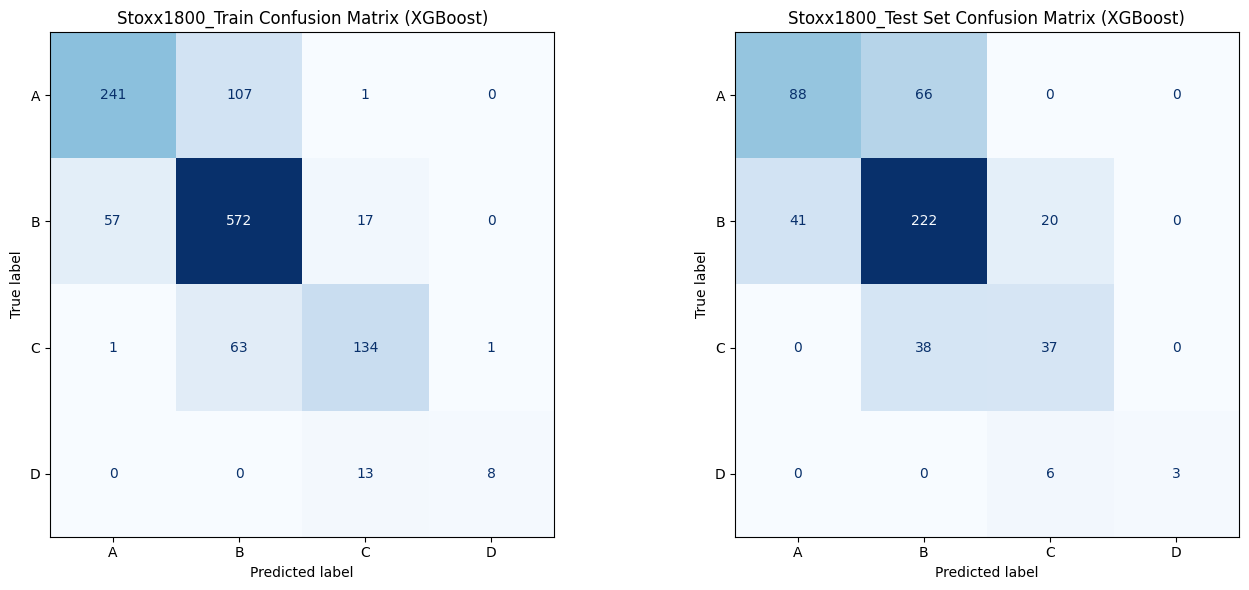

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# obtain the confusion matrices
train_confusion_matrix = confusion_matrix(y_train, tuned_xgb_model.predict(X_train))
test_confusion_matrix = confusion_matrix(y_test, tuned_xgb_model.predict(X_test))

# print the confusion matrices
print("\nTrain Confusion Matrix:\n", train_confusion_matrix)
print("Test Confusion Matrix:\n", test_confusion_matrix)

# visualize the confusion matrices
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# confusion matrix for training set
ConfusionMatrixDisplay(confusion_matrix=train_confusion_matrix, display_labels=label_encoder.classes_).plot(ax=ax[0], cmap=plt.cm.Blues, colorbar=False)
ax[0].set_title("Stoxx1800_Train Confusion Matrix (XGBoost)")

# confusion matrix for test set
ConfusionMatrixDisplay(confusion_matrix=test_confusion_matrix, display_labels=label_encoder.classes_).plot(ax=ax[1], cmap=plt.cm.Blues, colorbar=False)
ax[1].set_title("Stoxx1800_Test Set Confusion Matrix (XGBoost)")

plt.tight_layout()
plt.show()


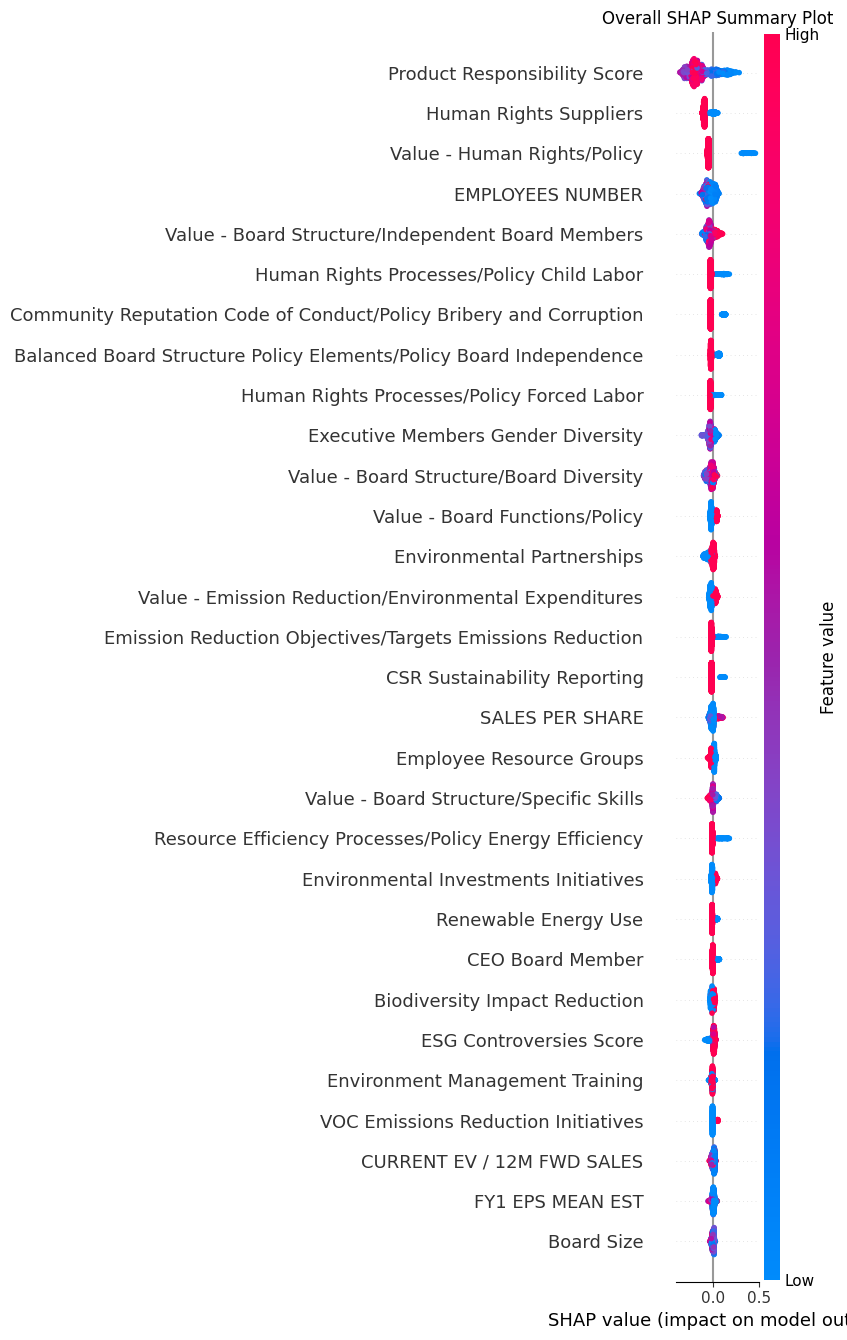

<Figure size 640x480 with 0 Axes>

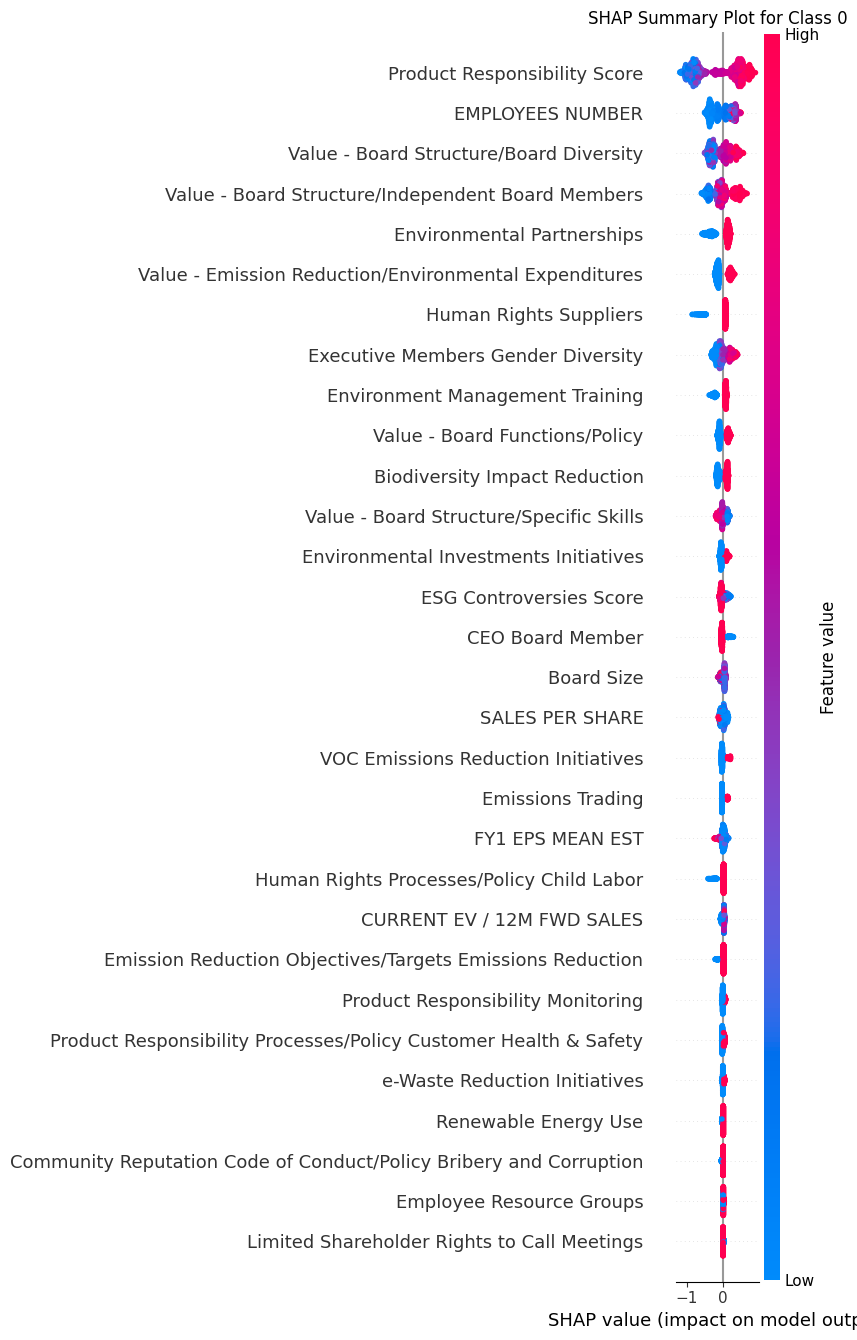

<Figure size 640x480 with 0 Axes>

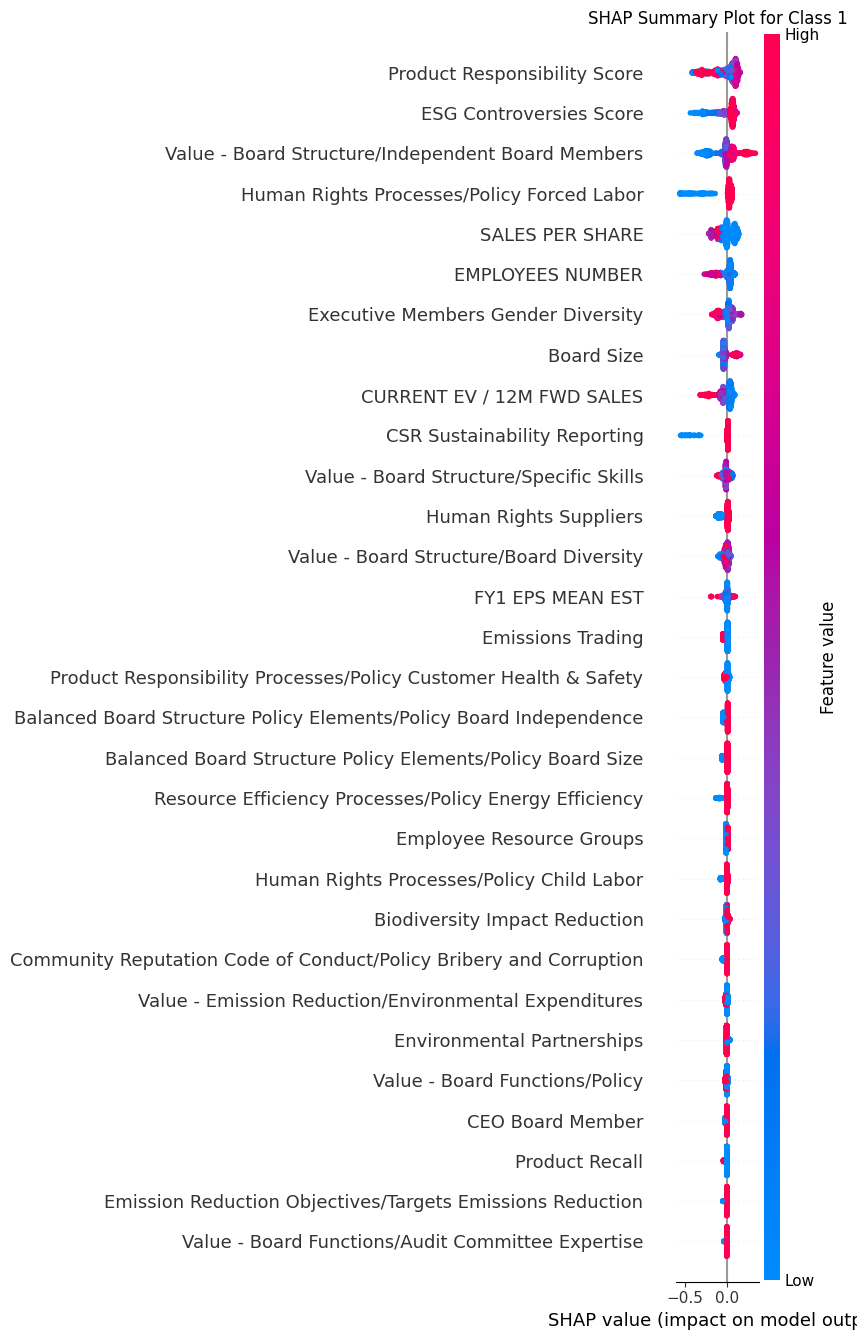

<Figure size 640x480 with 0 Axes>

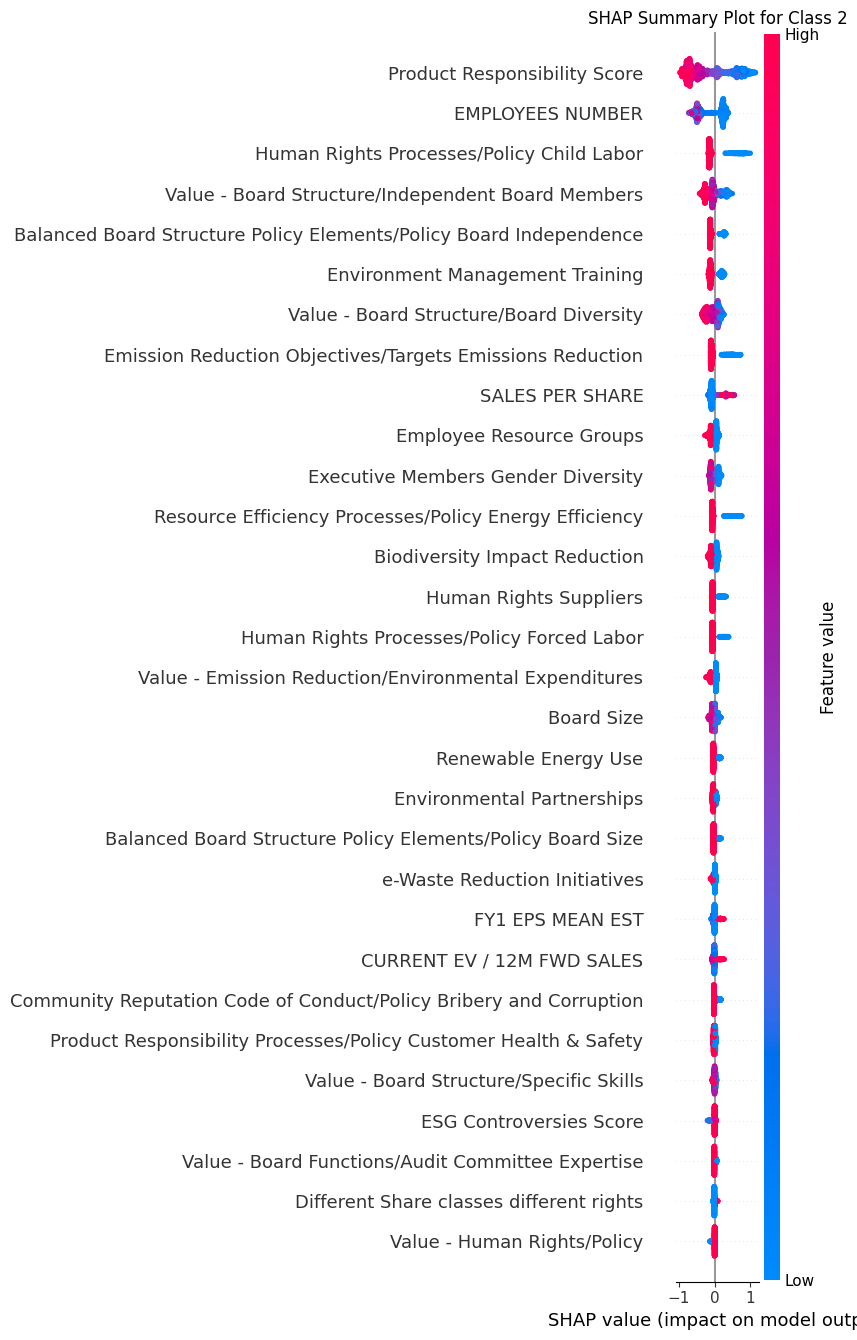

<Figure size 640x480 with 0 Axes>

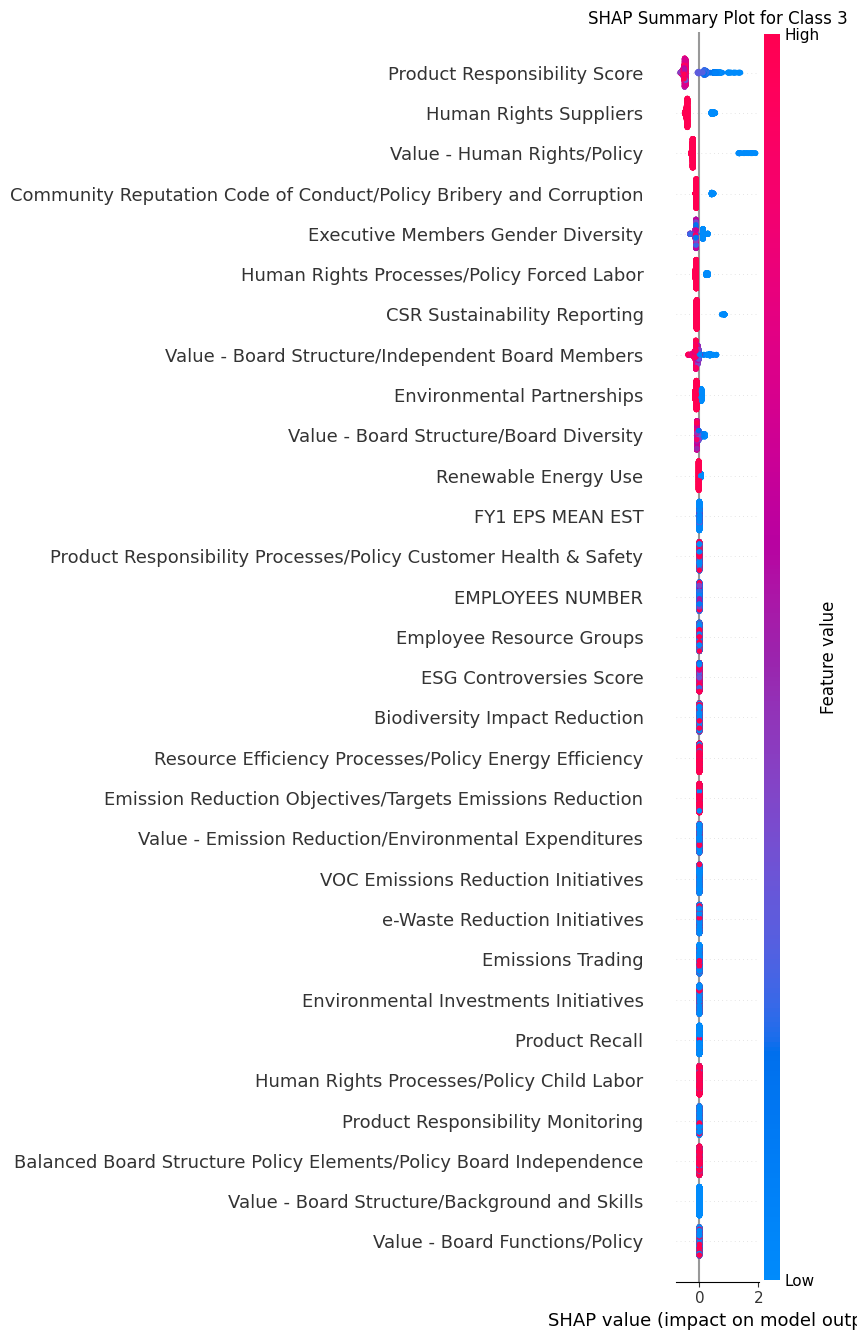

<Figure size 640x480 with 0 Axes>

In [ ]:
import shap
import matplotlib.pyplot as plt

# use the sharp to explain the model
explainer = shap.TreeExplainer(tuned_xgb_model)
shap_values = explainer.shap_values(X_train)

# plot the SHAP summary plot
# 将 SHAP 值按类别进行平均，得到总体 SHAP 值
shap_values_mean = shap_values.mean(axis=2)

plt.figure(figsize=(12, 6))
plt.title("Stoxx1800_SHAP Summary")
shap.summary_plot(shap_values_mean, X_train, feature_names=feature_names, max_display=30)
plt.tight_layout()  # 自动调整布局
plt.show()  # 显示图形

# plot the SHAP summary plot for each class
for i in range(shap_values.shape[2]):  # i 为类别索引
    plt.figure(figsize=(12, 6))
    plt.title(f"SHAP Summary Plot for Class {i}")
    shap.summary_plot(shap_values[:, :, i], X_train, feature_names=feature_names, max_display=30)
    plt.tight_layout()  # 自动调整布局
    plt.show()  # 显示图形


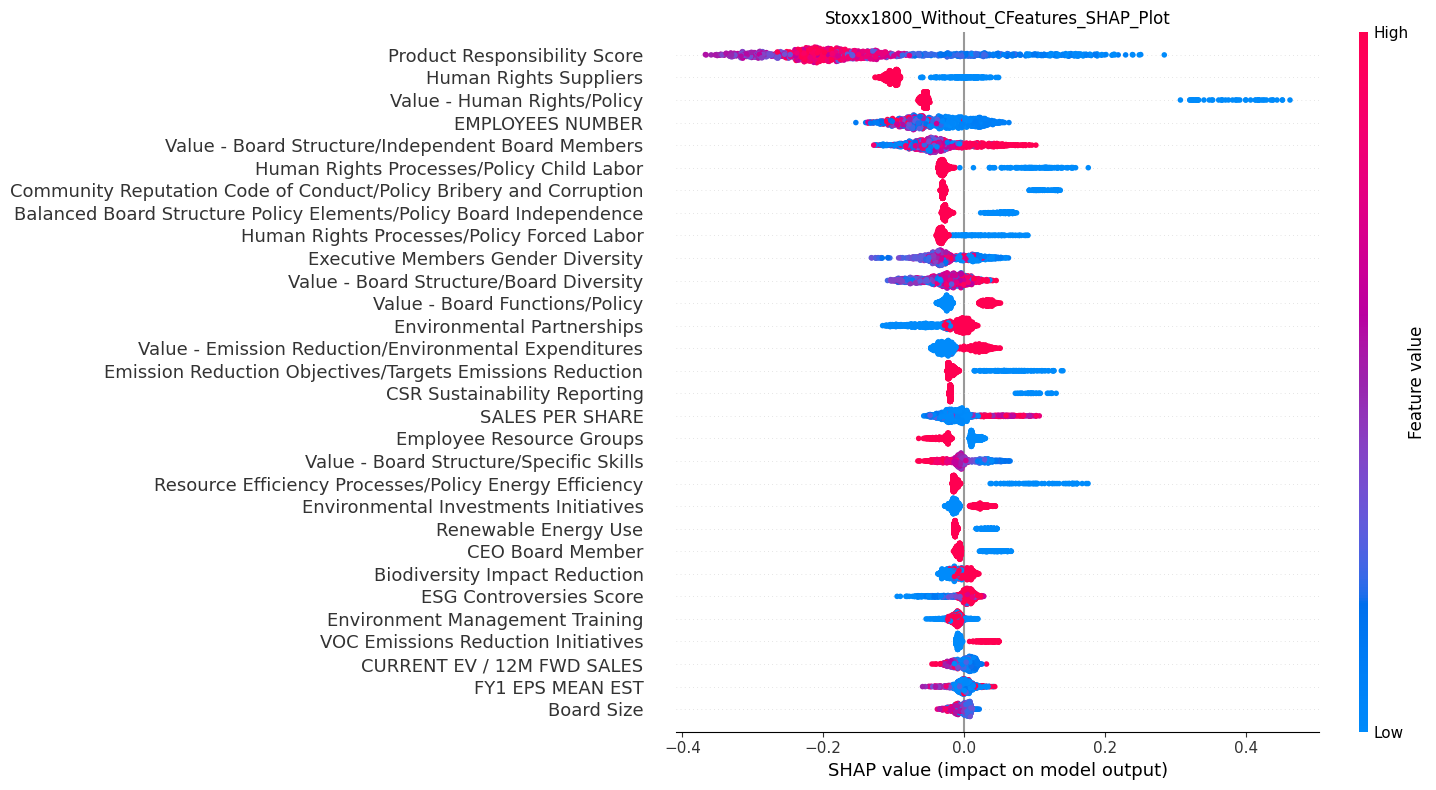

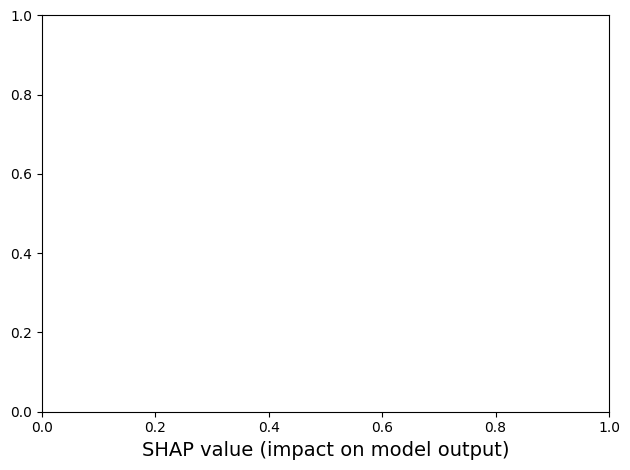

In [ ]:
import shap
import matplotlib.pyplot as plt
# use SHAP to explain the model
explainer = shap.TreeExplainer(tuned_xgb_model)
shap_values = explainer.shap_values(X_train)

# plot the SHAP summary plot
# average the SHAP values across classes to get the overall SHAP values
shap_values_mean = shap_values.mean(axis=2)

plt.figure(figsize=(15, 8))  # 增大图形尺寸
plt.title("Stoxx1800_Without_CFeatures_SHAP_Plot")
shap.summary_plot(shap_values_mean, X_train, feature_names=feature_names, max_display=30, plot_size=(15, 8))
plt.xlabel("SHAP value (impact on model output)", fontsize=14)  # 增大x轴标签字体
plt.tight_layout()  # 自动调整布局
plt.show()  # 显示图形